# Advanced pandas

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

## Categorical Data

### Background and Motivation

In [ ]:
import numpy as np; import pandas as pd
values = pd.Series(['apple', 'orange', 'apple',
                    'apple'] * 2)
print(values)
print(pd.unique(values))               #Returns the unique values
pd.value_counts(values)         #Returns the count of each unique value

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object
['apple' 'orange']


apple     6
orange    2
dtype: int64

In [ ]:
values = pd.Series([0, 1, 0, 0] * 2)
dim = pd.Series(['apple', 'orange'])
print(values)
dim

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64


0     apple
1    orange
dtype: object

In [ ]:
#Many data systems  have developed specialized approaches for representing data 
#with repeated values for more efficient storage and computation. 
#In data warehousing, a best practice is to use so called dimension tables 
#containing the distinct values and storing the primary observations 
#as integer keys referencing the dimension table:

dim.take(values)

#use the take method to restore the original Series of strings


#This representation as integers is called the categorical or dictionary-encoded 
#representation. The array of distinct values can be called the categories, 
#dictionary, or levels of the data. The integer values that reference the 
#categories are called the category codes or simply codes.

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

### Categorical Type in pandas

In [ ]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2
N = len(fruits)
df = pd.DataFrame({'fruit': fruits,
                   'basket_id': np.arange(N),
                   'count': np.random.randint(3, 15, size=N),
                   'weight': np.random.uniform(0, 4, size=N)},
                  columns=['basket_id', 'fruit', 'count', 'weight'])
df

type(df['fruit'])

pandas.core.series.Series

In [ ]:
#df['fruit'] is an array of Python string objects. We can convert it to categorical
#by calling:
fruit_cat = df['fruit'].astype('category')
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

In [ ]:
#The values for fruit_cat are not a NumPy array, 
#but an instance of pandas.Categorical:
c = fruit_cat.values
type(c)

pandas.core.arrays.categorical.Categorical

In [ ]:
#The Categorical object has categories and codes attributes:
print(c.categories)
c.codes

Index(['apple', 'orange'], dtype='object')


array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

In [ ]:
#You can convert a DataFrame column to categorical by assigning the converted result:
df['fruit'] = df['fruit'].astype('category')
df.fruit

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

In [ ]:
#create pandas.Categorical directly from other types of Python
#sequences:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])
my_categories

['foo', 'bar', 'baz', 'foo', 'bar']
Categories (3, object): ['bar', 'baz', 'foo']

In [ ]:
#If you have obtained categorical encoded data from another source, you can use the
#alternative from_codes constructor:
categories = ['foo', 'bar', 'baz']
codes = [0, 1, 2, 0, 0, 1]
my_cats_2 = pd.Categorical.from_codes(codes, categories)
my_cats_2

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo', 'bar', 'baz']

In [ ]:
#Unless explicitly specified, categorical conversions assume no specific ordering of the
#categories. So the categories array may be in a different order depending on the
#ordering of the input data. When using from_codes or any of the other constructors,
#you can indicate that the categories have a meaningful ordering:
ordered_cat = pd.Categorical.from_codes(codes, categories,
                                        ordered=True)
ordered_cat

#The output [foo < bar < baz] indicates that 'foo' precedes 'bar' in the ordering,
#and so on. 

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

In [ ]:
#An unordered categorical instance can be made ordered with as_ordered:
my_cats_2.as_ordered()



#categorical data need not be strings,a categorical array can consist of any 
#immutable value types.

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

### Computations with Categoricals

In [ ]:
np.random.seed(12345)
draws = np.random.randn(1000)
draws[:5]

array([-0.2047,  0.4789, -0.5194, -0.5557,  1.9658])

In [ ]:
bins = pd.qcut(draws, 4)
bins


#pandas.qcut binning functio returns pandas.Categorical

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] <
                                    (0.63, 3.928]]

In [ ]:
# quartile names can be assigned with labels argument to qcut:
bins = pd.qcut(draws, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
bins
bins.codes[:10]

array([1, 2, 1, 1, 3, 3, 2, 2, 3, 3], dtype=int8)

In [ ]:
#use groupby to extract some summary statistics
bins = pd.Series(bins, name='quartile')
results = (pd.Series(draws)
           .groupby(bins)
           .agg(['count', 'min', 'max'])
           .reset_index())
results

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


In [ ]:
results['quartile']

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

#### Better performance with categoricals

In [ ]:
#If you do a lot of analytics on a particular dataset, converting to categorical 
#can yield substantial overall performance gains. A categorical version of a 
#DataFrame column will often use significantly less memory, too. Let’s consider 
#some Series with 10 million elements and a small number of distinct categories
N = 10000000
draws = pd.Series(np.random.randn(N))
labels = pd.Series(['foo', 'bar', 'baz', 'qux'] * (N // 4))

In [ ]:
print(5/2)
print(5//2)

2.5
2


In [ ]:
#convert labels to categorical
categories = labels.astype('category')

In [ ]:
print(labels.memory_usage())
categories.memory_usage()

80000128


10000320

In [ ]:
#conversion to category is not free, of course, but it is a one-time cost
%time _ = labels.astype('category')



#GroupBy operations can be significantly faster with categoricals because the 
#underlying algorithms use the integer-based codes array instead of an array of 
#strings.

CPU times: user 476 ms, sys: 0 ns, total: 476 ms
Wall time: 479 ms


### Categorical Methods

In [ ]:
#Series containing categorical data have several special methods
s = pd.Series(['a', 'b', 'c', 'd'] * 2)
cat_s = s.astype('category')
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

In [ ]:
#The special attribute cat provides access to categorical methods:
print(cat_s.cat.codes)
cat_s.cat.categories

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8


Index(['a', 'b', 'c', 'd'], dtype='object')

In [ ]:
#Suppose that we know the actual set of categories for this data extends beyond the
#four values observed in the data. We can use the set_categories method to change
#them:
actual_categories = ['a', 'b', 'c', 'd', 'e']
cat_s2 = cat_s.cat.set_categories(actual_categories)
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

In [ ]:
print(cat_s.value_counts())
cat_s2.value_counts()

d    2
c    2
b    2
a    2
dtype: int64


d    2
c    2
b    2
a    2
e    0
dtype: int64

In [ ]:
#In large datasets, categoricals are often used as a convenient tool for 
#memory savings and better performance. After you filter a large DataFrame or 
#Series, many of the categories may not appear in the data. To help with this, 
#we can use the remove_unused_categories method to trim unobserved categories:
cat_s3 = cat_s[cat_s.isin(['a', 'b'])]
cat_s3
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): ['a', 'b']

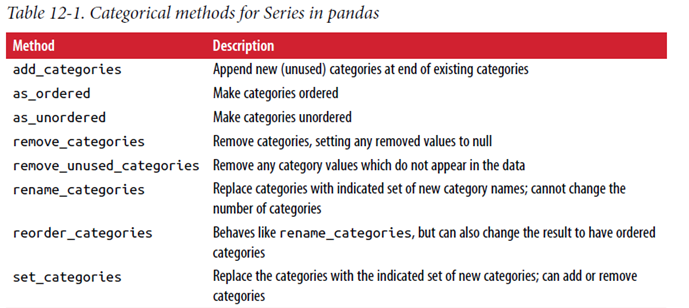

#### Creating dummy variables for modeling

In [ ]:
cat_s = pd.Series(['a', 'b', 'c', 'd'] * 2, dtype='category')

In [ ]:
#transform categorical data into dummy variables, also known as one-hot encoding. 
#This involves creating a DataFrame with a column for each distinct category; 
#these columns contain 1s for occurrences of a given category and 0 otherwise.
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


## Advanced GroupBy Use

### Group Transforms and "Unwrapped" GroupBys

In [ ]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4,
                   'value': np.arange(12.)})
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


In [ ]:
g = df.groupby('key').value
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

In [ ]:
#the apply method is used in grouped operations for performing transformations. 
#There is another built-in method called transform, which is similar
#to apply but imposes more constraints on the kind of function you can use:
#• It can produce a scalar value to be broadcast to the shape of the group
#• It can produce an object of the same shape as the input group
#• It must not mutate its input
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [ ]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [ ]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

In [ ]:
#compute the ranks in descending order for each group:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

In [ ]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [ ]:
print(g.transform(normalize))
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64


0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [ ]:
g.transform('mean')
normalized = (df['value'] - g.transform('mean')) / g.transform('std')
normalized

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

### Grouped Time Resampling

In [ ]:
#For time series data, the resample method is semantically a group operation 
#based on a time intervalization.
N = 15
times = pd.date_range('2017-05-20 00:00', freq='1min', periods=N)
df = pd.DataFrame({'time': times,
                   'value': np.arange(N)})
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


In [ ]:
#index by 'time' and then resample:
df.set_index('time').resample('5min').count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


In [ ]:

df2 = pd.DataFrame({'time': times.repeat(3),
                    'key': np.tile(['a', 'b', 'c'], N),     #constructs a new array by repeating array – 'arr', the number of times we want to repeat as per repetitions
                    'value': np.arange(N * 3.)})
df2[:7]

,time,key,value
0,2017-05-20 00:00:00,a,0.0
1,2017-05-20 00:00:00,b,1.0
2,2017-05-20 00:00:00,c,2.0
3,2017-05-20 00:01:00,a,3.0
4,2017-05-20 00:01:00,b,4.0
5,2017-05-20 00:01:00,c,5.0
6,2017-05-20 00:02:00,a,6.0


In [ ]:
time_key = pd.Grouper(freq='5min')      #TimeGrouper isnt working so go with Grouper

In [ ]:
resampled = (df2.set_index('time').groupby(['key', time_key]).sum())
print(resampled)
resampled.reset_index()

                         value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0


,key,time,value
0,a,2017-05-20 00:00:00,30.0
1,a,2017-05-20 00:05:00,105.0
2,a,2017-05-20 00:10:00,180.0
3,b,2017-05-20 00:00:00,35.0
4,b,2017-05-20 00:05:00,110.0
5,b,2017-05-20 00:10:00,185.0
6,c,2017-05-20 00:00:00,40.0
7,c,2017-05-20 00:05:00,115.0
8,c,2017-05-20 00:10:00,190.0


## Techniques for Method Chaining

```python
df = load_data()
df2 = df[df['col2'] < 0]
df2['col1_demeaned'] = df2['col1'] - df2['col1'].mean()
result = df2.groupby('key').col1_demeaned.std()
```

```python
# Usual non-functional way
df2 = df.copy()
df2['k'] = v

# Functional assign way
df2 = df.assign(k=v)
```

```python
result = (df2.assign(col1_demeaned=df2.col1 - df2.col2.mean())
          .groupby('key')
          .col1_demeaned.std())
```

```python
df = load_data()
df2 = df[df['col2'] < 0]
```

```python
df = (load_data()
      [lambda x: x['col2'] < 0])
```

```python
result = (load_data()
          [lambda x: x.col2 < 0]
          .assign(col1_demeaned=lambda x: x.col1 - x.col1.mean())
          .groupby('key')
          .col1_demeaned.std())
```

### The pipe Method

```python
a = f(df, arg1=v1)
b = g(a, v2, arg3=v3)
c = h(b, arg4=v4)
```

```python
result = (df.pipe(f, arg1=v1)
          .pipe(g, v2, arg3=v3)
          .pipe(h, arg4=v4))
```

```python
g = df.groupby(['key1', 'key2'])
df['col1'] = df['col1'] - g.transform('mean')
```

```python
def group_demean(df, by, cols):
    result = df.copy()
    g = df.groupby(by)
    for c in cols:
        result[c] = df[c] - g[c].transform('mean')
    return result
```

```python
result = (df[df.col1 < 0]
          .pipe(group_demean, ['key1', 'key2'], ['col1']))
```

In [ ]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS

## Conclusion